In [80]:
import pandas as pd
from pandas import DataFrame
import numpy as np

df_train = pd.read_csv('/home/zan/Desktop/dl_autoencoder/docs/autoencoder/deceptive_opinion_autoencoder/deceptive_training.csv')
df_test = pd.read_csv('/home/zan/Desktop/dl_autoencoder/docs/autoencoder/deceptive_opinion_autoencoder/deceptive_testing.csv')

In [81]:

x_train = ()
y_train = ()

for index, row in df_train.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_train = x_train + (res,)
    y_train = y_train + (row['deceptive'],)

x_test = ()
y_test = ()

for index, row in df_test.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_test = x_test + (res,)
    y_test = y_test + (row['deceptive'],)


In [82]:
import numpy as np
x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [86]:
x_train.shape

(597, 200)

In [89]:
import keras
from keras import layers,models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1DTranspose, Input
from keras import backend as BE


original_dim = 200
intermediate_dim = 20
latent_dim = 15 

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [91]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = BE.random_normal(shape=(BE.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + BE.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [92]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [94]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - BE.square(z_mean) - BE.exp(z_log_sigma)
kl_loss = BE.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = BE.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [97]:
history = vae.fit(x_train, x_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_test, x_test))

Epoch 1/100
19/19 [==============================] - 0s 3ms/step - loss: -1003.0374 - val_loss: -1003.2059
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: -1003.2063 - val_loss: -1003.1899
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: -1003.2899 - val_loss: -1003.2294
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: -1003.2867 - val_loss: -1003.4082
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: -1003.3859 - val_loss: -1003.3461
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: -1003.3194 - val_loss: -1003.0415
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: -1003.2278 - val_loss: -1003.2084
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: -1003.3300 - val_loss: -1003.1266
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: -1003.1444 - val_loss: -1003.3828
Epoch 10/100
19/19 [=================

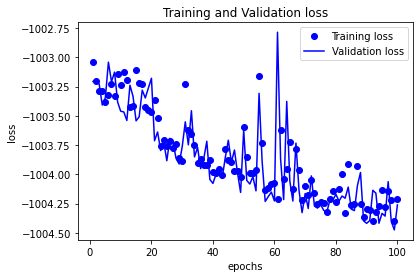

In [103]:
import matplotlib.pyplot as plt


history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
## Creamos el plot para mostrar el loss y val_loss durante los epochs

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [87]:
"""
import keras
from keras import layers,models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1DTranspose, Input

model = keras.Sequential([
    layers.Input(shape=(x_train.shape[0],x_train.shape[1])),
    layers.Conv1D( 32, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Dropout(rate=0.2),
    layers.Conv1D( 16, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Conv1DTranspose( 16, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Dropout(rate=0.2),
    layers.Conv1DTranspose( 32, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Conv1DTranspose(1, 7, padding="same"),
])
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = "mse")
model.summary()
"""

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 299, 32)           44832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 299, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 150, 16)           3600      
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 300, 16)           1808      
_________________________________________________________________
dropout_5 (Dropout)          (None, 300, 16)           0         
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 600, 32)           3616      
_________________________________________________________________
conv1d_transpose_8 (Conv1DTr (None, 600, 1)           

In [88]:
history = model.fit(
    x_train,
    x_train,
    epochs = 50,
    batch_size = 32,
    validation_split = 0.1,
    callbacks = [ 
        keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode="min")
    ]
)

Epoch 1/50


ValueError: in user code:

    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/zan/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: [None, 200]
